In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import plotly.express as px
import geopandas as gpd
import matplotlib.patches as mpatches

In [30]:
stations = pd.read_csv('11.17.25_Bluebikes_Station_List.csv', skiprows=1)
print(stations.head())

# Define the given latitude and longitude (center point)
center_lat = stations['Lat'].mean()
center_lon = stations['Long'].mean()

# Function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance to the center for each row
stations['distance_to_center'] = haversine(stations['Lat'], stations['Long'], center_lat, center_lon)
stations['far_from_center'] = stations['distance_to_center'] > 4


   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  
0                                           430  
1                                           412  
2                                           431  
3                                           427  
4                                           25

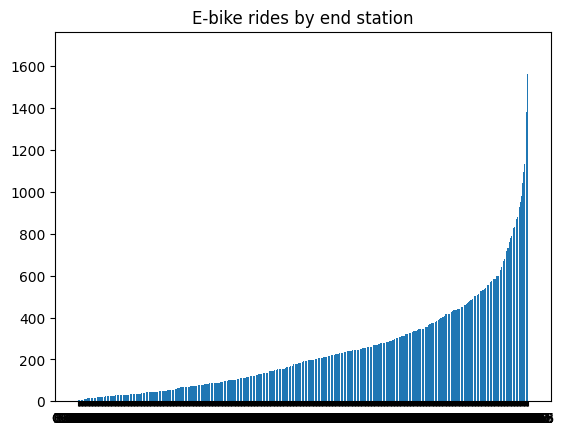

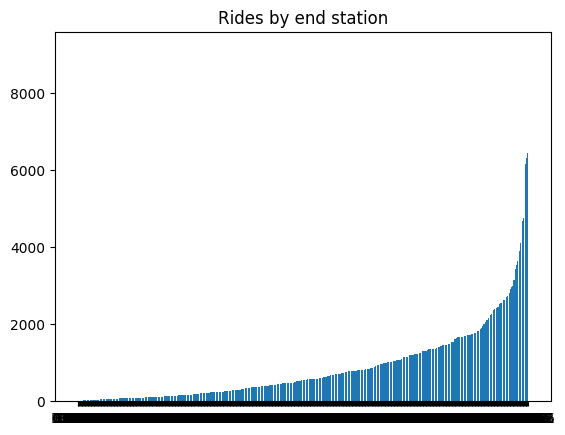

In [4]:
oct25trips = pd.read_csv('202510-bluebikes-tripdata.csv')
oct25started = oct25trips.groupby('end_station_id').describe()['start_lat']
oct25started = oct25started.sort_values(by='count')

ebikes = oct25trips[oct25trips['rideable_type'] == 'electric_bike']

ebikes_by_endpoint = ebikes.groupby('end_station_id').describe()['end_lat']
ebikes_by_endpoint = ebikes_by_endpoint.sort_values(by='count')

plt.bar(ebikes_by_endpoint.index, ebikes_by_endpoint['count'])
plt.title('E-bike rides by end station')
plt.show()

plt.bar(oct25started.index,oct25started['count'])
plt.title('Rides by end station')
plt.show()

In [32]:

stations = stations.merge(
    oct25started[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=oct25started.index  # Column in oct25started to join on
)


stations = stations.merge(
    ebikes_by_endpoint[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=ebikes_by_endpoint.index  # Column in oct25started to join on
)

stations = stations.rename(columns = {'count_x': 'count_all_bikes', 'count_y': 'count_ebikes'} )

# Ensure the columns are Series, not DataFrames
stations['count_all_bikes'] = stations['count_all_bikes'].squeeze()
stations['count_ebikes'] = stations['count_ebikes'].squeeze()

stations['ratio_ebikes'] = stations['count_ebikes'] / stations['count_all_bikes'].replace(0, np.nan)


print(stations.head())

   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  distance_to_center  \
0                                           430            9.334084   
1                                           412            2.392088   
2                                           431            8.783920   
3           

In [33]:
from matplotlib.colors import to_hex
import branca.colormap as colm
# Create a folium map centered at the average latitude and longitude
station_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)
threshold_red = 0.3
cm = plt.get_cmap('cool')



# Create a colormap using branca that matches the matplotlib colormap
colormap = colm.LinearColormap(
    colors=[to_hex(plt.get_cmap('cool')(i)) for i in range(256)],
    vmin=stations['ratio_ebikes'].min(),
    vmax=stations['ratio_ebikes'].max(),
    caption='Ratio of E-Bikes'  # Add a caption for the color bar
)

# Add CircleMarkers for each station
for _, row in stations.iterrows():

    color = to_hex(cm(row['ratio_ebikes']))
    
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius= max( (row['count_ebikes']) // 70,3),  # Marker size
        color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill=True,
        fill_color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill_opacity=0.6,
        popup=f"Name: {row['NAME']}, e-bike count: {row['count_ebikes']}"  # Optional popup with station name
    ).add_to(station_map)
    
# Add the colormap to the map
colormap.add_to(station_map)

display(station_map)

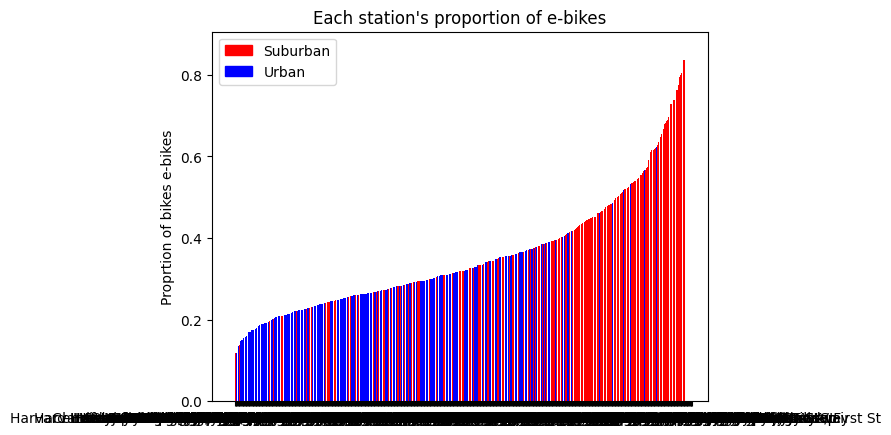

In [7]:
# stations_sorted = stations[stations['far_from_center'] == True].sort_values(by='ratio_ebikes')
stations_sorted = stations.sort_values(by='ratio_ebikes')


# print(f"Most dense ebikes : {stations.nlargest(10, 'ratio_ebikes')[['NAME', 'count_ebikes', 'ratio_ebikes', 'far_from_center']]}")
# print(f"Most total ebikes : {stations.nlargest(10, 'count_ebikes')[['NAME', 'count_ebikes','ratio_ebikes', 'far_from_center']]}")

plt.ylabel('Proprtion of bikes e-bikes')
plt.title("Each station's proportion of e-bikes")

colors = stations_sorted['far_from_center'].apply(lambda x: 'red' if x == 1 else 'blue')

plt.bar(stations_sorted['NAME'], stations_sorted['count_ebikes'] / stations_sorted['count_all_bikes'],color=colors)
red_patch = mpatches.Patch(color='red', label='Suburban')
blue_patch = mpatches.Patch(color='blue', label='Urban')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

C:\Users\Julie\AppData\Local\Temp\ipykernel_18604\2696010862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])
C:\Users\Julie\AppData\Local\Temp\ipykernel_18604\2696010862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])


       end_station_id                ended_at              started_at  \
83927          A32000 2025-10-01 07:28:16.905 2025-10-01 07:24:13.095   
69291          A32000 2025-10-01 11:31:02.051 2025-10-01 11:17:04.138   
398546         A32000 2025-10-01 11:50:24.140 2025-10-01 11:44:07.119   
83533          A32000 2025-10-01 13:38:17.325 2025-10-01 13:33:37.063   
8563           A32000 2025-10-01 14:57:26.876 2025-10-01 14:41:21.520   

                 elapsed_time  
83927  0 days 04:02:45.146000  
69291  0 days 00:19:22.089000  
398546 0 days 01:47:53.185000  
83533  0 days 01:19:09.551000  
8563   0 days 00:45:23.389000  


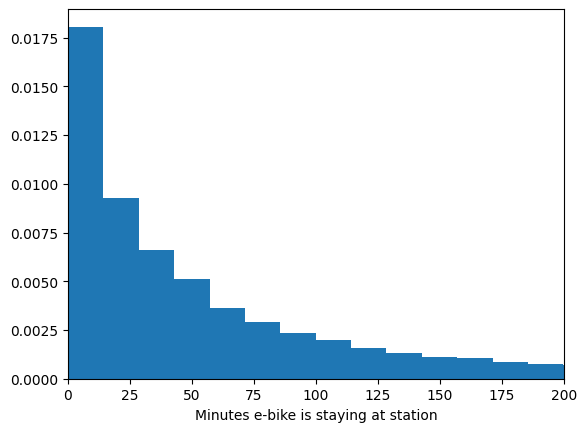

In [8]:
# Ensure 'ended_at' and 'started_at' are in datetime format
ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])
ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])

# Sort the DataFrame by 'station' and 'ended_at'
ebikes = ebikes.sort_values(by=['end_station_id', 'ended_at'])

# Shift columns to get the next row's values
ebikes['next_started_at'] = ebikes['ended_at'].shift(-1)
ebikes['next_start_station'] = ebikes['end_station_id'].shift(-1)

# Calculate elapsed time only if the end station matches the next start station
ebikes['elapsed_time'] = ebikes.apply(
    lambda row: row['next_started_at'] - row['ended_at']
    if row['end_station_id'] == row['next_start_station'] else pd.NaT,
    axis=1
)

# Display the DataFrame with the new column
print(ebikes[['end_station_id', 'ended_at', 'started_at', 'elapsed_time']].head())

ebikes['elapsed_time'] = ebikes['elapsed_time'].apply(lambda x: x.total_seconds()// 60)

plt.hist(ebikes['elapsed_time'], bins=1500, density=True)
plt.xlim((0,200))
plt.xlabel('Minutes e-bike is staying at station')
plt.show()

# note: roughly looks like a pareto distribution?

involves_city
True     0.870659
False    0.129341
Name: proportion, dtype: float64


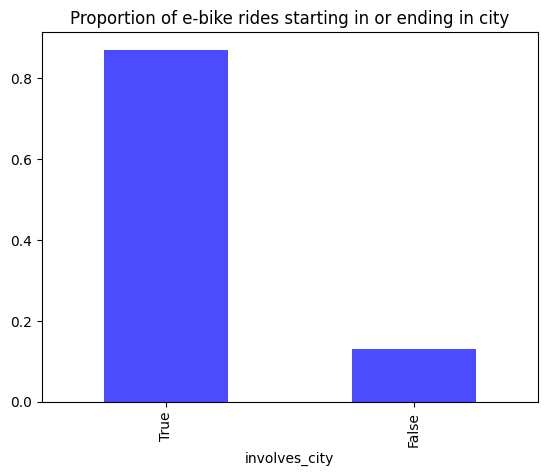

In [9]:
# Get the station IDs where 'far_from_center' is False
near_center_stations = stations.loc[stations['far_from_center'] == False, 'Number']

# Check if start_station_id or end_station_id is in the list of near-center stations
ebikes['involves_city'] = ebikes['start_station_id'].isin(near_center_stations) | ebikes['end_station_id'].isin(near_center_stations)

city_rides = ebikes['involves_city'].value_counts(normalize=True)
print(city_rides)

city_rides.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in city')
plt.show()

involves_suburbs
False    0.64381
True     0.35619
Name: proportion, dtype: float64


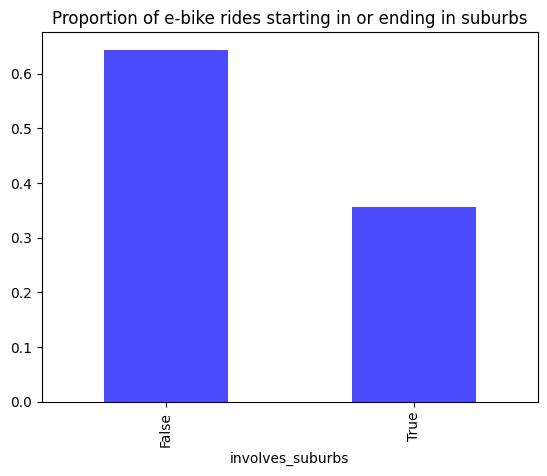

In [10]:
# what fraction of e-bike rides involve at least one point far from center

# Get the station IDs where 'far_from_center' is False
far_center_stations = stations.loc[stations['far_from_center'] == True, 'Number']

# Check if start_station_id or end_station_id is in the list of near-center stations
ebikes['involves_suburbs'] = ebikes['start_station_id'].isin(far_center_stations) | ebikes['end_station_id'].isin(far_center_stations)

suburb_rides = ebikes['involves_suburbs'].value_counts(normalize=True)
print(suburb_rides)

suburb_rides.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in suburbs')
plt.show()


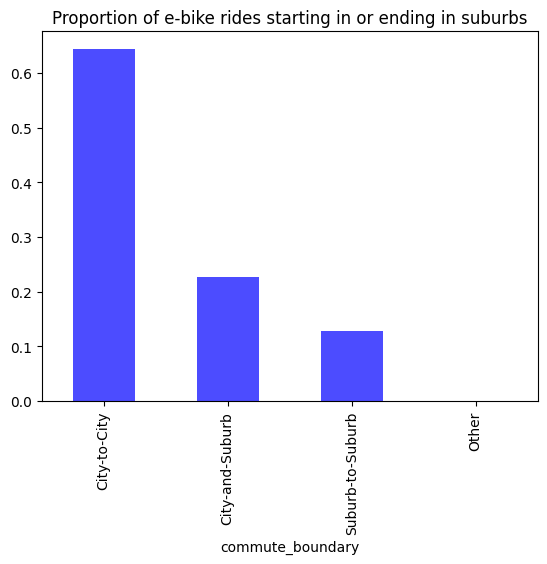

In [11]:
# city-to-city, "long haul" commute, or suburb-to-suburb
# Define the conditions
conditions = [
    (ebikes['involves_city'] == True) & (ebikes['involves_suburbs'] == False),  # CC
    (ebikes['involves_city'] == True) & (ebikes['involves_suburbs'] == True),   # CS
    (ebikes['involves_city'] == False) & (ebikes['involves_suburbs'] == True)   # SS
]

# Define the corresponding values
choices = ['City-to-City', 'City-and-Suburb', 'Suburb-to-Suburb']

# Create the new column
ebikes['commute_boundary'] = np.select(conditions, choices, default='Other')

commutes = ebikes['commute_boundary'].value_counts(normalize=True)

commutes.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Proportion of e-bike rides starting in or ending in suburbs')
plt.show()


In [12]:
# Count of Total Starts and Ends by Station

ebikes_by_start = ebikes.groupby(['start_station_id']).size().reset_index(name='num_starts')
ebikes_by_start = ebikes_by_start.sort_values(by='num_starts', ascending=False)

ebikes_by_end = ebikes.groupby(['end_station_id']).size().reset_index(name='num_ends')
ebikes_by_end = ebikes_by_end.sort_values(by='num_ends', ascending=False)

station_lookup = stations.set_index('Number')['NAME']                                            # Set dictionaries for map func to reference
ebikes_by_start['start_station_name'] = ebikes_by_start['start_station_id'].map(station_lookup)
ebikes_by_end['end_station_name'] = ebikes_by_end['end_station_id'].map(station_lookup)

ebikes_by_start

,start_station_id,num_starts,start_station_name
117,B32065,1674,Massachusetts Ave at Boylston St.
2,A32002,1558,Commonwealth Ave at Agganis Way
395,M32006,1388,MIT at Mass Ave / Amherst St
405,M32018,1380,Harvard Square at Mass Ave/ Dunster
398,M32011,1199,Central Square at Mass Ave / Essex St
...,...,...,...
224,C32100,5,Hyde Park Ave at Arlington St
335,E32014,5,Ross Playground
349,F32011,5,Carr Park
225,C32101,4,American Legion Hwy at Hyde Park Ave


In [13]:
# Frequency of Each Unique Route (station i to station j)

ebikes_by_trip = ebikes.groupby(['start_station_id','end_station_id']).size().reset_index(name='num_trips')
ebikes_by_trip = ebikes_by_trip.sort_values(by='num_trips', ascending=False)

station_lookup = stations.set_index('Number')['NAME']                                            # Set dictionaries for map func to reference
station_lat = stations.set_index('Number')['Lat']
station_long = stations.set_index('Number')['Long']

ebikes_by_trip['start_station_name'] = ebikes_by_trip['start_station_id'].map(station_lookup)    # Names of start and end stations
ebikes_by_trip['end_station_name'] = ebikes_by_trip['end_station_id'].map(station_lookup)

ebikes_by_trip['start_lat'] = ebikes_by_trip['start_station_id'].map(station_lat)              # Coordinates for start station
ebikes_by_trip['start_long'] = ebikes_by_trip['start_station_id'].map(station_long)

ebikes_by_trip['end_lat'] = ebikes_by_trip['end_station_id'].map(station_lat)                  # Coordinates for end station
ebikes_by_trip['end_long'] = ebikes_by_trip['end_station_id'].map(station_long)

ebikes_by_trip['Linear Trip Distance'] = haversine(ebikes_by_trip['start_lat'], ebikes_by_trip['start_long'], ebikes_by_trip['end_lat'], ebikes_by_trip['end_long'])

ebikes_by_trip

,start_station_id,end_station_id,num_trips,start_station_name,end_station_name,start_lat,start_long,end_lat,end_long,Linear Trip Distance
340,A32002,B32060,136,Commonwealth Ave at Agganis Way,Commonwealth Ave at Granby St,42.351692,-71.119035,42.349609,-71.103915,1.263884
12169,B32060,A32002,130,Commonwealth Ave at Granby St,Commonwealth Ave at Agganis Way,42.349609,-71.103915,42.351692,-71.119035,1.263884
12744,B32063,B32062,107,St. Alphonsus St at Tremont St,Forsyth St at Huntington Ave,42.333293,-71.101246,42.339202,-71.090511,1.100197
398,A32002,D32032,90,Commonwealth Ave at Agganis Way,Silber Way,42.351692,-71.119035,42.349496,-71.100576,1.536433
8956,B32016,M32006,89,Beacon St at Massachusetts Ave,MIT at Mass Ave / Amherst St,42.350827,-71.089811,42.358100,-71.093198,0.855295
...,...,...,...,...,...,...,...,...,...,...
53461,Z32998,M32063,1,Broadway at Kittie Knox Bike Path,Sennott Park Broadway at Norfolk Street,42.364127,-71.087386,42.368605,-71.099302,1.098330
23123,D32006,M32037,1,Lewis Wharf at Atlantic Ave,Ames St at Main St,42.363871,-71.050877,42.362500,-71.088220,3.071910
53459,Z32998,M32061,1,Broadway at Kittie Knox Bike Path,Mass Ave at Albany St,42.364127,-71.087386,42.361358,-71.096703,0.825021
23122,D32006,M32034,1,Lewis Wharf at Atlantic Ave,EF - North Point Park,42.363871,-71.050877,42.369885,-71.069957,1.704217


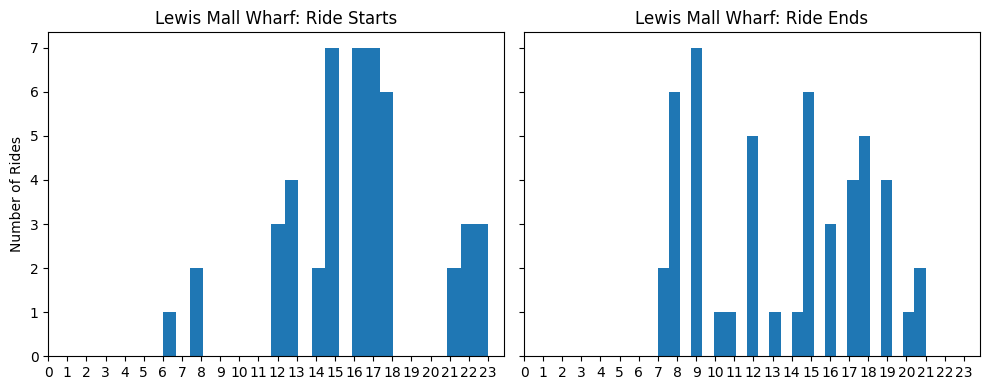

In [103]:
# Plotting Time Distribution of Inbound and Outbound Volume for a Station

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True, sharey=True)

# Ensure Date Time Type
ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])
ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])

station_id = 'A32057'
station_name = station_lookup[station_id]

# Station Starts (Outbound)
ebikes_station_start = ebikes.loc[ebikes['start_station_id'] == station_id].copy()
ebikes_station_start['start_hour'] = ebikes_station_start['started_at'].dt.hour

axs[0].hist(ebikes_station_start['start_hour'], bins=24)
axs[0].set_title(f"{station_name}: Ride Starts")
axs[0].set_ylabel('Number of Rides')

# Station Ends (Inbound)
ebikes_station_end = ebikes.loc[ebikes['end_station_id'] == station_id].copy()
ebikes_station_end['end_hour'] = ebikes_station_end['ended_at'].dt.hour

axs[1].hist(ebikes_station_end['end_hour'], bins=24)
axs[1].set_title(f"{station_name}: Ride Ends")

# Formatting
for ax in axs.flat:
    ax.set_xticks(range(24))

plt.tight_layout()
plt.show()

#### Using Quantiles -- measure which stations have more concentrated bike use

minimize difference between 25th and 75th percentile in minute of ride start?

In [98]:
ebikes['start_minutes'] = (ebikes['started_at'].dt.hour * 60 + ebikes['started_at'].dt.minute)
station_quantiles = (ebikes.groupby('start_station_id')['start_minutes'].quantile([0.25, 0.75]).unstack().rename(columns={0.25: 'q25', 0.75: 'q75'}))
station_quantiles['difference'] = station_quantiles['q75'] - station_quantiles['q25']  # Adding difference between quantiles
station_quantiles = station_quantiles.sort_values(by='difference')

station_lookup = stations.set_index('Number')['NAME']
station_quantiles['station_name'] = station_quantiles.index.map(station_lookup)  # Adding station name
station_quantiles = station_quantiles[['station_name', 'q25', 'q75', 'difference']]  # Reorder columns

station_quantiles.head(30)

,station_name,q25,q75,difference
start_station_id,,,,
F32011,Carr Park,403.00,407.00,4.00
E32014,Ross Playground,1029.00,1048.00,19.00
C32100,Hyde Park Ave at Arlington St,712.00,763.00,51.00
C32039,Park St at Norwell St,899.75,994.25,94.50
T32012,Salem MBTA - Lower Level,967.75,1085.25,117.50
N32013,Newton Library,919.00,1052.00,133.00
E32018,Truman Parkway at Fairmount Ave,914.00,1049.00,135.00
N32008,Union St at Herrick Rd,896.00,1042.75,146.75
S32060,Middlesex Ave at Foley St,841.00,993.50,152.50


### Starts per Dock per Station

In [15]:
# Number of Departures per Dock per Station

docks_map = stations.set_index('Number')['Total Docks']

ebikes_by_start['starts_per_dock'] = ebikes_by_start['start_station_id'].map(docks_map)

ebikes_by_start['starts_per_dock'] = ebikes_by_start['num_starts'] / ebikes_by_start['starts_per_dock']

ebikes_by_start = ebikes_by_start[np.isfinite(ebikes_by_start['starts_per_dock'])]
ebikes_by_start.sort_values(by='starts_per_dock', ascending=False)

,start_station_id,num_starts,start_station_name,starts_per_dock
2,A32002,1558,Commonwealth Ave at Agganis Way,103.866667
405,M32018,1380,Harvard Square at Mass Ave/ Dunster,72.631579
117,B32065,1674,Massachusetts Ave at Boylston St.,69.750000
114,B32062,1037,Forsyth St at Huntington Ave,69.133333
398,M32011,1199,Central Square at Mass Ave / Essex St,63.105263
...,...,...,...,...
501,R32007,4,Revere Public Library,0.363636
88,B32024,6,Pilgrim Rd at Brookline Ave,0.315789
224,C32100,5,Hyde Park Ave at Arlington St,0.263158
335,E32014,5,Ross Playground,0.263158


### Metric: Max Min Distance

This fairness metric will determine which $k$ stations out of $n$ total stations to electrify such that we minimize the maximum of minimum distance from any station $x_i$ to an electrified station $x_j$: $$ \max_{i \in n} \left( \min_{k \in j} d(x_i, x_j) \right) $$

#### Set station coordinates and distance matrix (includes all $n$ stations in matrix)

In [16]:
# Import to generate combinations of possible k stations
from itertools import combinations

# Set station coordinates
coordinates = stations.set_index('Number')[['Lat', 'Long']].to_dict('index')
station_ids = list(coordinates.keys())

# Precompute distance matrix
lat = stations['Lat'].values
lon = stations['Long'].values
coordinates = np.column_stack((lat, lon))

lat1 = coordinates[:, None, 0]
lat2 = coordinates[None, :, 0]
lon1 = coordinates[:, None, 1]
lon2 = coordinates[None, :, 1]
dist_matrix = haversine(lat1, lon1, lat2, lon2)

# Map station ID to index in matrix
id_to_idx = {station_id: idx for idx, station_id in enumerate(station_ids)}

#### Max Min -- choosing $k$ electrified stations from top $m$ stations by inbound bike volume

In [17]:
k = 5  # Set to number of stations to electrify
m = 30 # Set to number of stations to consider when choosing k

first_m = ebikes_by_start['start_station_id'].iloc[:m]
combos = list(combinations(first_m, k))


# Compute max distance for each combo
maxmin_list = []
for combo in combos:
    combo_idx = [id_to_idx[ID] for ID in combo]        # Convert station IDs to indices in distance matrix
    min_dists = dist_matrix[:, combo_idx].min(axis=1)  # Get distance to nearest station in combo for all stations
    max_dist = min_dists.max()                         # Max distance from any station to nearest in combo
    maxmin_list.append({'elec-stations': combo, 'max-dist': max_dist})


# Convert to DataFrame
maxmin_table = pd.DataFrame(maxmin_list)
maxmin_table = maxmin_table.sort_values(by='max-dist')

# Displaying results
print(maxmin_table.head(10))
best_combo = maxmin_table['elec-stations'].iloc[0]

print("Stations List:")
for i in range(k):
    station = stations.set_index('Number').loc[best_combo[i], 'NAME']
    print(station)

                                   elec-stations   max-dist
142458  (B32008, C32016, D32006, M32013, M32061)  24.091749
142459  (B32008, C32016, D32006, C32017, M32061)  24.091749
45      (B32065, A32002, M32006, M32011, D32006)  24.091749
142436  (D32010, D32006, B32000, B32032, C32017)  24.091749
142437  (D32010, D32006, B32000, B32032, M32061)  24.091749
142438  (D32010, D32006, B32000, M32013, C32017)  24.091749
142439  (D32010, D32006, B32000, M32013, M32061)  24.091749
142440  (D32010, D32006, B32000, C32017, M32061)  24.091749
142479  (B32008, D32006, M32013, C32017, M32061)  24.091749
142452  (B32008, C32016, D32006, B32000, C32017)  24.091749
Stations List:
Boston City Hall - 28 State St
W Broadway at Dorchester St
Lewis Wharf at Atlantic Ave
Cambridge Main Library at Broadway / Trowbridge St
Mass Ave at Albany St


#### Max Min -- choosing $k$ electrified stations from top $m$ stations by inbound bike volume AND all Salem stations

In [18]:
k = 5  # Set to number of stations to electrify
m = 30 # Set to number of stations to consider when choosing k

# Set of all IDs (station included if in the top m for inbound or if in Salem
first_m = ebikes_by_start['start_station_id'].iloc[:m]
salem_ids = stations.loc[stations['Municipality'] == 'Salem', 'Number']
combined_ids = pd.concat([first_m, salem_ids]).unique()

combos = list(combinations(combined_ids, k))

# Compute max distance for each combo
maxmin_list = []
for combo in combos:
    combo_idx = [id_to_idx[ID] for ID in combo]        # Convert station IDs to indices in distance matrix
    min_dists = dist_matrix[:, combo_idx].min(axis=1)  # Get distance to nearest station in combo for all stations
    max_dist = min_dists.max()                         # Max distance from any station to nearest in combo
    maxmin_list.append({'elec-stations': combo, 'max-dist': max_dist})


# Convert to DataFrame
maxmin_table = pd.DataFrame(maxmin_list)
maxmin_table = maxmin_table.sort_values(by='max-dist')

# Displaying results
maxmin_table
best_combo = maxmin_table['elec-stations'].iloc[0]

print("Stations List:")
for i in range(k):
    station = stations.set_index('Number').loc[best_combo[i], 'NAME']
    print(station)
print()

Stations List:
Commonwealth Ave at Agganis Way
Central Square at Mass Ave / Essex St
Christian Science Plaza - Massachusetts Ave at Westland Ave
Charles Circle - Charles St at Cambridge St
Salem Willows Park



#### Max Min -- function to input $k$ stations

In [19]:
def maxmin_k_stations(bike_stations):                          # bike_stations = list of station IDs as strings ['id1','id2',...]
    stations_idx = [id_to_idx[ID] for ID in bike_stations]     # Convert station IDs to indices in distance matrix
    min_dists = dist_matrix[:, stations_idx].min(axis=1)       # Get distance to nearest station in combo for all stations
    max_dist = min_dists.max()   
    return max_dist

my_stations = ['B32065','A32002','M32006']  # Adjust list IDs and number of IDs as needed
dist = maxmin_k_stations(my_stations)

print("Max Distance:", dist)
print("--Stations List--")
for i in range(len(my_stations)):
    station = stations.set_index('Number').loc[my_stations[i], 'NAME']
    print(station)

Max Distance: 26.83705506974455
--Stations List--
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
MIT at Mass Ave / Amherst St


#### Max Min -- excluding Salem stations from total list of $n$ stations, top $m$ stations by inbound volume

In [60]:
# Set station coordinates
stations_filtered = stations[stations['Municipality'] != 'Salem'].copy()
coordinates = stations_filtered.set_index('Number')[['Lat', 'Long']].to_dict('index')
station_ids = list(coordinates.keys())

# Precompute Distance Matrix
lat = stations_filtered['Lat'].values
lon = stations_filtered['Long'].values
coordinates = np.column_stack((lat, lon))

lat1 = coordinates[:, None, 0]
lat2 = coordinates[None, :, 0]
lon1 = coordinates[:, None, 1]
lon2 = coordinates[None, :, 1]
dist_matrix = haversine(lat1, lon1, lat2, lon2)

# Map station ID to index in matrix
id_to_idx = {station_id: idx for idx, station_id in enumerate(station_ids)}

k = 3  # Set to number of stations to electrify
m = 30 # Set to number of stations to consider when choosing k

first_m = ebikes_by_start['start_station_id'].iloc[:m]
combos = list(combinations(first_m, k))


# Compute max distance for each combo
maxmin_list = []
for combo in combos:
    combo_idx = [id_to_idx[ID] for ID in combo]        # Convert station IDs to indices in distance matrix
    min_dists = dist_matrix[:, combo_idx].min(axis=1)  # Get distance to nearest station in combo for all stations
    max_dist = min_dists.max()                         # Max distance from any station to nearest in combo
    maxmin_list.append({'elec-stations': combo, 'max-dist': max_dist})


# Convert to DataFrame
maxmin_table = pd.DataFrame(maxmin_list)
maxmin_table = maxmin_table.sort_values(by='max-dist')

# Displaying results
print(maxmin_table.head(10))
best_combo = maxmin_table['elec-stations'].iloc[0]

print("Best Stations List:")
for i in range(k):
    station = stations.set_index('Number').loc[best_combo[i], 'NAME']
    print(station)

                elec-stations  max-dist
729  (A32002, A32004, C32036)  10.58606
568  (A32002, B32002, D32006)  10.58606
570  (A32002, B32002, B32032)  10.58606
574  (A32002, A32046, B32005)  10.58606
544  (A32002, B32062, D32010)  10.58606
543  (A32002, B32062, C32036)  10.58606
547  (A32002, B32062, D32006)  10.58606
545  (A32002, B32062, B32008)  10.58606
559  (A32002, B32002, D32000)  10.58606
556  (A32002, B32002, D32016)  10.58606
Best Stations List:
Commonwealth Ave at Agganis Way
Longwood Ave at Binney St
Seaport Blvd at Sleeper St


### Metric: Charging Time Score

The goal of this metric is to determine which stations balance high daytime usage with low nighttime usage/longer low usage blocks to allow for adequate charging windows (i.e. if the busiest station in Boston has bikes leaving every 5 minutes throughout the day, will the charging actually be useful?)
$$N_i(t,\Delta) = \text{the number of departures from station } i \text{ in the time window } [t, t+\Delta)$$
where $\Delta$ is a time interval amount to bucket the data. Then, let $\tau$ be a threshold for the number of departures in the window considered to be efficient (consider using the nth percentile of the top m stations as the threshold?) Then, we can say that the total charging time available at station $i$ in the day is: $$C_i = \sum_t \mathbb{1} \{N_i(t,\Delta) \leq \tau\} \cdot \Delta$$ 
where the indicator function is equal to 1 if the number of departures in the window is below the threshold $\tau$.\

The least used stations have the highest values for $C_i$, so instead of using the total number of charging minutes, the code above produces a charging score that considers both available minutes for charging and total number of departures over the month with the measure $$\text{charging score} = \text{number of departures} \cdot \frac{\text{number of downtime 30min intervals}}{\text{total number of intervals}}$$
The charging score should be highest when both downtime and number of departures are high (should consider that significantly higher numbers of departures skew results)

In [83]:
e_bikes = oct25trips[oct25trips['rideable_type'] == 'electric_bike'].copy()
e_bikes['started_at'] = pd.to_datetime(e_bikes['started_at'])

delta = '30min'

e_bikes['time_bucket'] = e_bikes['started_at'].dt.floor(delta)
departures = (e_bikes.groupby(['start_station_id', 'time_bucket']).size().reset_index(name='num_departures'))
departures = departures.sort_values(by='num_departures', ascending=False)

# Fill in the empty time intervals (when there were no departures)
full_range = pd.date_range(start = e_bikes['started_at'].min().floor(delta), end = e_bikes['started_at'].max().ceil(delta), freq = delta)
bikestations = e_bikes['start_station_id'].unique()
full_index = pd.MultiIndex.from_product([bikestations, full_range], names = ['start_station_id','time_bucket'])
departures = (departures.set_index(['start_station_id', 'time_bucket']).reindex(full_index, fill_value=0).reset_index())

TAU = 2 # max number of departures in the time window to consider it a charging window (downtime) for a station
        # should this be changed based on number of docks at station?

departures['is_downtime'] = departures['num_departures'] <= TAU  # classifies a 30min interval as downtime/charging if there at <= 2 departures
downtime_fraction = (departures.groupby('start_station_id')['is_downtime'].mean().rename('downtime_fraction'))  # number of charging intervals / total number of intervals
                                                                                                  # calculated per station

U_i = (e_bikes.groupby('start_station_id').size().rename('U_i'))  # Total number of departures over the month for each station

charging_score = (U_i * downtime_fraction).sort_values(ascending=False)  # (total number of departures in month) * ( # charging intervals / total intervals)


charging_score_df = charging_score.reset_index()
charging_score_df.columns = ['start_station_id', 'charging_score']

charging_score_df = charging_score_df.merge(downtime_fraction.reset_index(), on='start_station_id', how='left')

station_lookup = stations.set_index('Number')['NAME']
charging_score_df['station_name'] = charging_score_df['start_station_id'].map(station_lookup)

charging_score_df.head()

,start_station_id,charging_score,downtime_fraction,station_name
0,B32065,1392.570663,0.831882,Massachusetts Ave at Boylston St.
1,A32002,1360.771601,0.873409,Commonwealth Ave at Agganis Way
2,M32006,1229.955794,0.886135,MIT at Mass Ave / Amherst St
3,M32018,1211.774950,0.878098,Harvard Square at Mass Ave/ Dunster
4,M32011,1090.584059,0.909578,Central Square at Mass Ave / Essex St


### Transition Matrix & Markov Chain

#### Making Transition Matrix

In [ ]:
trips = oct25trips[oct25trips['rideable_type'] == 'electric_bike'].copy()

ebike_trips = trips.groupby(['start_station_id','end_station_id']).size().reset_index(name='num_trips')
ebike_trips = ebike_trips.sort_values(by='num_trips', ascending=False)

matrix = ebike_trips.pivot(index='start_station_id', columns='end_station_id', values='num_trips')
matrix = matrix.fillna(0)

stations_state = (matrix.index.union(matrix.columns).sort_values())
transition_matrix = matrix.div(matrix.sum(axis=1),axis=0).fillna(0)

# Issue with stations with no departures / outgoing trip, since they effectively become absorbing
zero_rows = transition_matrix.sum(axis=1) == 0
transition_matrix.loc[zero_rows, :] = 1 / len(stations_state)

sim_table = stations[['Number','Total Docks','ratio_ebikes']].copy()
sim_table = sim_table.set_index('Number')

sim_table['start_bikes'] = sim_table['Total Docks'] * sim_table['ratio_ebikes']
sim_table['start_bikes'] /= sim_table['start_bikes'].sum()

phi0 = sim_table['start_bikes'].reindex(stations_state, fill_value=0)

# Checks for correct values
print(transition_matrix.shape[0] == transition_matrix.shape[1])  # Check for square matrix
print(transition_matrix.sum(axis=1).round(6).eq(1).all())        # Check that rows sum to 1
print(phi0.sum().round(6) == 1)                                  # Check that starting state (phi0) sums to 1
print((phi0.index == transition_matrix.index).all())             # Check that station orders are identical in phi0 and matrix


(590, 590)
True
True
True
True


#### Finding Steady State Distribution $\pi = \pi P$

In [ ]:
P = transition_matrix.to_numpy()
phi = phi0.to_numpy()

tol = 1e-12
max_iter = 10000

for _ in range(max_iter):
    phi_next = phi @ P
    if np.allclose(phi_next, phi, atol=tol):
        break
    phi = phi_next

stationary_dist = pd.Series(phi, index=stations_state)
stationary_dist /= stationary_dist.sum()  # ensure sums to 1

id_to_name = stations.set_index('Number')['NAME']

stationary_with_names = stationary_dist.to_frame('Proportion')
stationary_with_names['Station'] = stationary_with_names.index.map(id_to_name)

stationary_with_names = stationary_with_names.sort_values('Proportion', ascending=False)

print(stationary_with_names.head(10))

        Proportion                                            Station
B32065    0.011487                  Massachusetts Ave at Boylston St.
A32002    0.010742                    Commonwealth Ave at Agganis Way
M32018    0.009423                Harvard Square at Mass Ave/ Dunster
M32006    0.009329                       MIT at Mass Ave / Amherst St
M32011    0.008163              Central Square at Mass Ave / Essex St
C32008    0.007712                        Boylston St at Fairfield St
A32010    0.007390                   South Station - 700 Atlantic Ave
B32062    0.007200                       Forsyth St at Huntington Ave
B32002    0.007068  Ruggles T Stop - Columbus Ave at Melnea Cass Blvd
A32046    0.006590                            Canal St at Causeway St


#### Making $k$ stations absorbing, minimizing expected number of trips to absorbing

In [65]:
def avg_exp_steps_to_absorption(absorbing_stations):
    P_absorbing = transition_matrix.copy()
    for station in absorbing_stations:    
        P_absorbing.loc[station, :] = 0
        P_absorbing.loc[station, station] = 1

    transient_states = [s for s in P_absorbing.index if s not in absorbing_stations]
    new_order = transient_states + list(absorbing_stations)
    P_canonical = P_absorbing.reindex(index=new_order, columns=new_order)

    n_transient = len(transient_states)
    Q = P_canonical.iloc[:n_transient, :n_transient].to_numpy()
    I = np.eye(n_transient)
    N = np.linalg.inv(I - Q)
    t = N.sum(axis=1)
    return t.sum() / len(t)  # weight the expected values by proportion of rides leaving/arriving at station instead of averaging?


k = 3  # Set to number of stations to electrify
m = 20 # Set to number of stations to consider when choosing k

first_m = ebikes_by_start['start_station_id'].iloc[:m].tolist()
combos = list(combinations(first_m, k))

absorption_list = []
for combo in combos:
    avg_exp_steps = avg_exp_steps_to_absorption(combo)
    absorption_list.append({'elec-stations': combo, 'avg-exp-steps-to-abs': avg_exp_steps})

absorption_table = pd.DataFrame(absorption_list)
absorption_table = absorption_table.sort_values(by='avg-exp-steps-to-abs')

In [68]:
print("Stations List:")
for j in range(10):
    print(f"Rank #{j}")
    best_combo = absorption_table['elec-stations'].iloc[j]
    for i in range(len(best_combo)):
        station = stations.set_index('Number').loc[best_combo[i], 'NAME']
        print(station)
    print()

Stations List:
Rank #0
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
Harvard Square at Mass Ave/ Dunster

Rank #1
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
MIT at Mass Ave / Amherst St

Rank #2
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
Central Square at Mass Ave / Essex St

Rank #3
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
South Station - 700 Atlantic Ave

Rank #4
Massachusetts Ave at Boylston St.
Commonwealth Ave at Agganis Way
Boylston St at Fairfield St

Rank #5
Massachusetts Ave at Boylston St.
MIT at Mass Ave / Amherst St
Harvard Square at Mass Ave/ Dunster

Rank #6
Massachusetts Ave at Boylston St.
Harvard Square at Mass Ave/ Dunster
Boylston St at Fairfield St

Rank #7
Massachusetts Ave at Boylston St.
Harvard Square at Mass Ave/ Dunster
South Station - 700 Atlantic Ave

Rank #8
Massachusetts Ave at Boylston St.
Harvard Square at Mass Ave/ Dunster
Central Square at Mass Ave / Essex St

Ra

#### Simulation - to do